## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import copy
import numpy
import csv
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [69]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/ecol/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/ecol/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/ecol/'
gtf_name = 'Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.51.gtf'
mutation = 'efp'
samp_num = '1'
#if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
#    pre_load = True
#else:
#    pre_load = False

## Loading up the data files 

In [70]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [71]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [72]:
# clear up some memory by deleting original transcript list
transcripts.clear()

## Loading up the csv file.

In [73]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

## Loading up elongation rates. 

In [74]:
my_gene = "cysQ"

with open(elon_path + mutation + '_' + my_gene + '_' + samp_num +'.csv') as mutant:
    arr_m = np.loadtxt(mutant, delimiter=",")
    
with open(elon_path + 'control' + '_' + my_gene + '_' + samp_num +'.csv') as control:
    arr_c = np.loadtxt(control, delimiter=",")

In [75]:
np.where(arr_m == np.amin(arr_m[30:]))[0][0]

116

In [132]:
np.where(x == 9.0)

(array([], dtype=int64),)

In [127]:
np.amin(x)

1.0

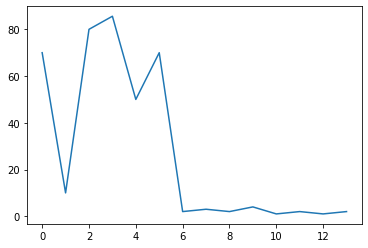

In [178]:
plt.plot(x)

In [177]:
x = [70,10,80,85.6,50,70,2,3,2,4,1,2,1,2]
xmax = np.amax(x)
np.amax(np.where(x > xmax*0.9)[0])

3

In [181]:
x[:2]

[70, 10]

In [182]:
ratios = []
for j,i in zip(x, list(range(len(x)))):
    front = np.mean(x[i:])
    behind = np.mean(x[:i])
    ratios.append(front/behind)

---------------------------------------------------------------------------
RuntimeWarning
Mean of empty slice.
in /home/keeganfl/miniconda3/envs/plastid/lib/python3.8/site-packages/numpy/core/fromnumeric.py, line 3440:

3438             return mean(axis=axis, dtype=dtype, out=out, **kwargs)
3440     return _methods._mean(a, axis=axis, dtype=dtype,
3441                           out=out, **kwargs)

---------------------------------------------------------------------------
---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in double_scalars
in /home/keeganfl/miniconda3/envs/plastid/lib/python3.8/site-packages/numpy/core/_methods.py, line 189:

187             ret = arr.dtype.type(ret / rcount)
188         else:
189             ret = ret.dtype.type(ret / rcount)
190     else:
191         ret = ret / rcount

---------------------------------------------------------------------------


In [190]:
np.where(ratios == np.nanmin(ratios))[0][0]

6

In [201]:
def alter_p_ethan(arr_c, arr_m, I = 10):
    lam_c = copy.deepcopy(arr_c)
    lam_m = copy.deepcopy(arr_m)
    Jmax = min(lam_c)/((1+np.sqrt(I))**2)
    crit_a = ((lam_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lam_c[0]*Jmax)/((lam_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lam_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lam_c[-1]*Jmax)/((lam_c[-1] - (I - 1)*Jmax)**2)))
    a = crit_a * 0.80
    B = crit_B * 1.2
    mut_min = np.amin(lam_m)
    el_p = np.amax(np.where(lam_m < mut_min*2)[0])
    print(el_p)
    while True:
        lam_c[el_p] = lam_c[el_p]*0.9 # It keeps doing this every run through. 
        Jmax = min(lam_c)/((1+np.sqrt(I))**2)
        crit_a = ((lam_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lam_c[0]*Jmax)/((lam_c[0] - (I - 1)*Jmax)**2)))
        crit_B = ((lam_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lam_c[-1]*Jmax)/((lam_c[-1] - (I - 1)*Jmax)**2)))
        if crit_a < a and crit_B < B:
            break
    p = kat.maximum_current(lam_c,a=a,B=B,I = 10)
    return p

In [202]:
altered_p = alter_p_ethan(arr_c, arr_m)

215


In [203]:
position = np.array(list(range(len(altered_p))))
sm_m, cumul_m = kat.get_smoothed_vector(position, pbar_m+0.000001, frac = 0.05)
sm_c, cumul_c = kat.get_smoothed_vector(position, pbar_c+0.000001, frac = 0.05)
sm_p, cumul_p = kat.get_smoothed_vector(position, altered_p+0.000001, frac = 0.05)

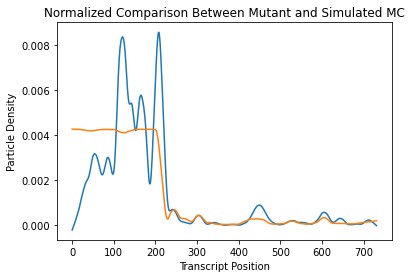

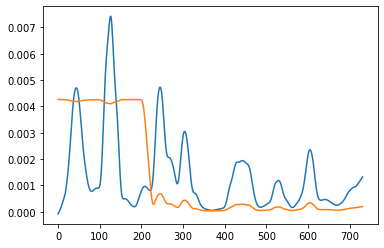

In [204]:
plt.plot(sm_m)
plt.plot(sm_p)
plt.ylabel("Particle Density")
plt.xlabel("Transcript Position")
plt.title("Normalized Comparison Between Mutant and Simulated MC")
plt.show()
plt.plot(sm_c)
plt.plot(sm_p)

Text(0.5, 1.0, 'Elongation Limited Control')

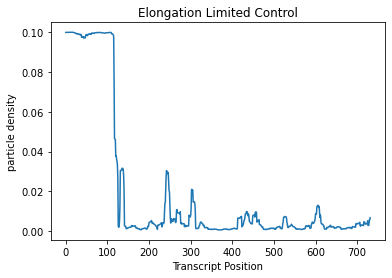

In [78]:
plt.plot(altered_p)
plt.ylabel("particle density")
plt.xlabel("Transcript Position")
plt.title("Elongation Limited Control")

In [79]:
my_transcript, tr_m, tr_c, index = kat.find_transcripts(my_gene, protein_coding, data_mutant, data_control, )
position = np.array(list(range(len(tr_m))))

In [80]:
# calculate the normalized profile (p) of my vector of interest
def get_p(tr_m):
    M = sum(tr_m)
    p = tr_m/M
    return(p)

In [81]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
def get_pbar_from_count(tr_m):
    M = sum(tr_m)
    p = tr_m/M
    x=0
    pbar=[]
    for px in p:
        pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
        pbar.append(pbar_x )
        x = x+1
        if x  == len(p)-9:
            break
    pbar = np.array(pbar)
    return(pbar)

In [82]:
pbar_m = get_pbar_from_count(tr_m)
pbar_c = get_pbar_from_count(tr_c)

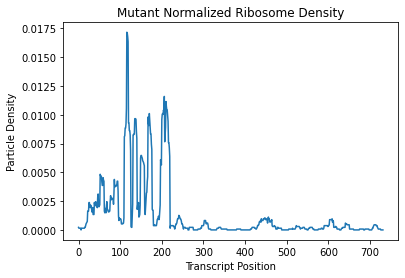

Text(0.5, 1.0, 'Control Normalized Ribosome Density')

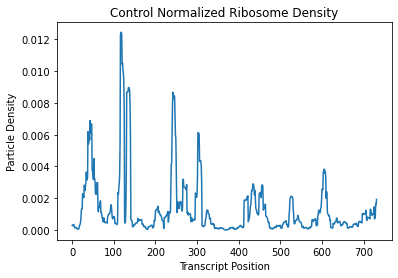

In [83]:
plt.plot(pbar_m)
plt.ylabel("Particle Density")
plt.xlabel("Transcript Position")
plt.title("Mutant Normalized Ribosome Density")
plt.show()
plt.plot(pbar_c)
plt.ylabel("Particle Density")
plt.xlabel("Transcript Position")
plt.title("Control Normalized Ribosome Density")

In [84]:
position = np.array(list(range(len(altered_p))))
sm_m, cumul_m = kat.get_smoothed_vector(position, pbar_m+0.000001, frac = 0.05)
sm_c, cumul_c = kat.get_smoothed_vector(position, pbar_c+0.000001, frac = 0.05)
sm_p, cumul_p = kat.get_smoothed_vector(position, altered_p+0.000001, frac = 0.05)

Text(0.5, 1.0, 'comparison between mutant and simulated MC')

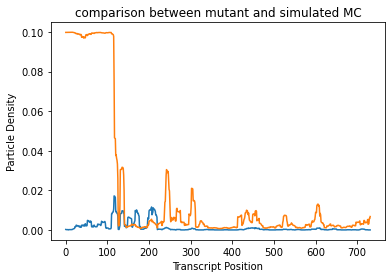

In [85]:
plt.plot(pbar_m)
plt.plot(altered_p)
plt.ylabel("Particle Density")
plt.xlabel("Transcript Position")
plt.title("comparison between mutant and simulated MC")

In [86]:
for d, i in zip(sm_m, list(range(len(sm_m)))):
    if d < 0:
        sm_m[i] = 0.000000000000000000001

In [87]:
for d, i in zip(sm_c, list(range(len(sm_c)))):
    if d < 0:
        sm_c[i] = 0.000000000000000000001

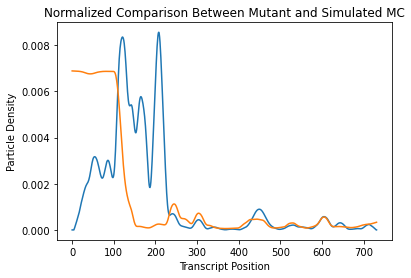

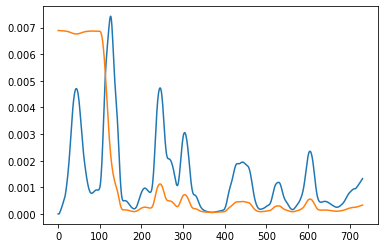

In [88]:
plt.plot(sm_m)
plt.plot(sm_p)
plt.ylabel("Particle Density")
plt.xlabel("Transcript Position")
plt.title("Normalized Comparison Between Mutant and Simulated MC")
plt.show()
plt.plot(sm_c)
plt.plot(sm_p)

Is ultra smoothing appropriate here? It would certainly get the results we are looking for but that does not necessarily mean it is the right thing to do. Then again, I do remeber them mentioning smoothing a couple of times. For now I think I should clean this up until I can ask Ethan about it. 

Ugh, there is no reason behind that pretty plot of ultra smooth vs altered_p. I might as well just be squishing the data together however I feel like it. Not to mention the fact that I am effectively cutting off 90 reads when I do this. 

Are we comparing this to particle density in a general sense or particle density in the specific universe of Khanh's equations? If it is in the universe of Khanh's equations then how would we choose the correct alpha and beta values? would it even matter if we do the normalization? again, how do we choose the normalization? Is it appropriate to make assumptions about what regime it is in? It feels like that last one is really not appropriate. 

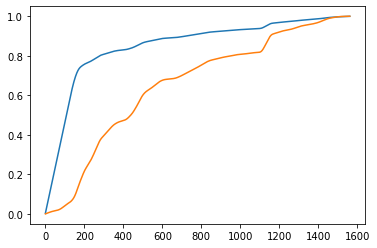

In [53]:
plt.plot(cumul_p)
plt.plot(cumul_c)

In [52]:
max(abs(cumul_p - cumul_c))

0.5964866722527975

0.89 for hrpA
0.23 for valS
0.84 for cysQ (note that this is the one with the wrong pause site phenomenon)
0.32 for rpoB
The smoothing on the mutant data was done using a 90 codon sliding window average. 

0.76 for hrpA
0.277 for valS
0.209 for rpoB
Double smoothing (both use 10 codon sliding average and then both use loess.)
(is it possible that KL is changing with the length of the transcripts. )

use the cumulative distribution to see when the slope changes the most. 
make a sliding window and then find where the biggest differences are before and after. 